# Player Price Prediction Model

This notebook develops a deep learning model to predict a player's market `value_euro`.

**Key Methodologies:**

1.  **Target Variable Transformation**: The target variable, `value_euro`, is highly right-skewed. To normalize its distribution and aid model training, we apply a **logarithmic transformation (`np.log1p`)**. The model will be trained to predict the log of the value, which is then converted back to its original scale using `np.expm1` for evaluation.
2.  **Comprehensive Feature Selection**: We select a wide range of features that influence a player's market value, including on-field performance, potential, age, and reputation.
3.  **Robust Preprocessing**: Numerical features are scaled using `StandardScaler`, and categorical features like `nationality` are handled by grouping less frequent ones into an 'Other' category before one-hot encoding.
4.  **Advanced Model Architecture**: A deep neural network with **Batch Normalization** and **Dropout** is employed to learn complex patterns and prevent overfitting.
5.  **Optimized Training**: `EarlyStopping` and `ReduceLROnPlateau` callbacks are used for efficient and effective training.

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
import json

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


### 2. Load and Prepare Data

In [2]:
# Load the dataset
df = pd.read_csv('fifa_players_cleaned.csv')

# Filter out players with zero or invalid values
df = df[(df['value_euro'] > 0) & (df['release_clause_euro'] > 0)].copy()

print(f"Total players with valid data: {len(df)}")

Total players with valid data: 17954


In [3]:
# Set some important variables
target = 'value_euro'
TEST_SIZE = 0.2

#### 2.1 Log-Transform the Target Variable

Player market values are highly skewed. Applying a log transform helps normalize the distribution, which is beneficial for model training.

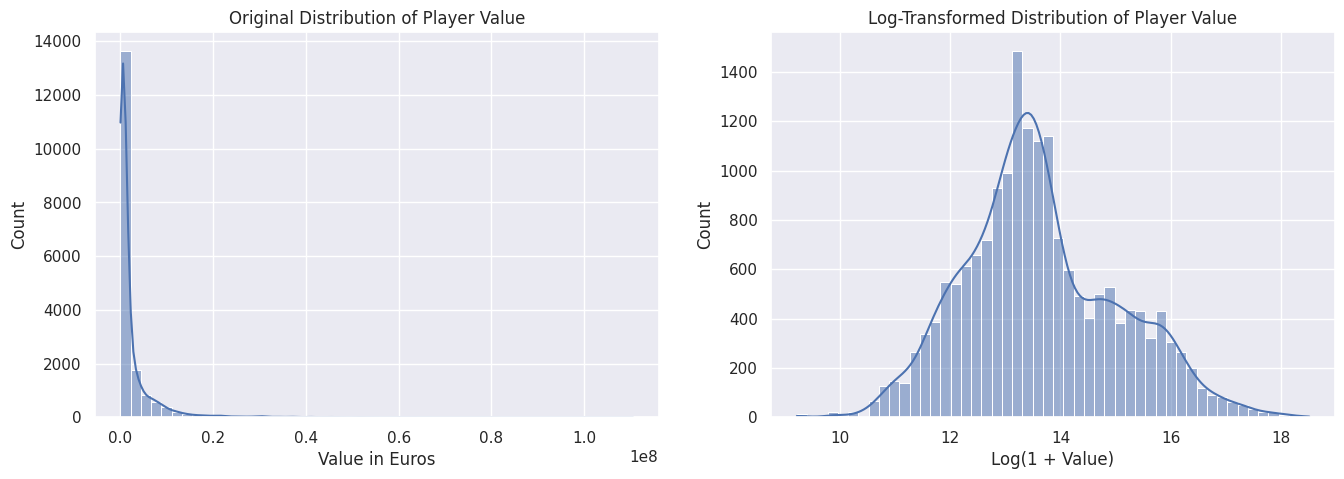

In [4]:
# Apply log transformation to the target variable
df[target] = np.log1p(df[target])

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(np.expm1(df[target]), ax=ax[0], kde=True, bins=50)
ax[0].set_title('Original Distribution of Player Value')
ax[0].set_xlabel('Value in Euros')

sns.histplot(df[target], ax=ax[1], kde=True, bins=50)
ax[1].set_title('Log-Transformed Distribution of Player Value')
ax[1].set_xlabel('Log(1 + Value)')

plt.show()

# Also transform release clause, which is also skewed
df['release_clause_euro'] = np.log1p(df['release_clause_euro'])

### 2.2 Feature Selection

We select features that logically contribute to a player's market value, including:
- **Performance Metrics**: `overall_rating`, `potential`, `reactions`.
- **Financial Indicators**: `wage_euro`, `release_clause_euro`.
- **Market Factors**: `age`, `international_reputation(1-5)`.
- **Core Skills**: A wide range of technical and physical attributes.

In [5]:
features = [
    # Performance Metrics
    'overall_rating', 'potential', 'reactions',
    # Financial Indicators
    'wage_euro', 'release_clause_euro',
    # Market Factors & Traits
    'age', 'international_reputation(1-5)', 'skill_moves(1-5)', 'weak_foot(1-5)',
    # Elite Skills
    'composure', 'vision', 'short_passing', 'long_passing', 'ball_control', 'dribbling',
    # Physical Attributes
    'acceleration', 'sprint_speed', 'agility', 'stamina', 'strength', 'shot_power',
    # Categorical Features
    'positions', 'body_type', 'nationality'
]

df_model = df[features + [target]].copy()

# Handle nationality by grouping less frequent ones
top_n_nationalities = 30
top_nationalities = df_model['nationality'].value_counts().nlargest(top_n_nationalities).index
df_model['nationality'] = df_model['nationality'].where(df_model['nationality'].isin(top_nationalities), 'Other')

print("Selected features for the model:")
df_model.head()

Selected features for the model:


,overall_rating,potential,reactions,wage_euro,release_clause_euro,age,international_reputation(1-5),skill_moves(1-5),weak_foot(1-5),composure,...,acceleration,sprint_speed,agility,stamina,strength,shot_power,positions,body_type,nationality,value_euro
0,94,94,95,565000.0,19.238256,31,5,4,4,96,...,91,86,93,72,66,85,"CF,RW,ST",Messi,Argentina,18.520526
1,88,89,88,205000.0,18.711857,27,3,4,5,88,...,76,73,80,92,58,84,"CAM,RM,CM",Lean,Denmark,18.056837
2,88,91,82,255000.0,18.786712,25,4,5,4,87,...,71,79,76,88,87,90,"CM,CAM",Normal,France,18.105970
3,88,88,83,165000.0,18.473273,27,3,4,4,83,...,94,86,94,75,44,75,"LW,ST",Normal,Italy,17.942645
4,88,91,82,135000.0,18.483656,27,3,2,3,80,...,70,75,50,75,94,55,CB,Normal,Other,17.909855


### 3. Preprocessing

In [6]:
# Separate features and target
X = df_model.drop(target, axis=1)
y = df_model[target]

# Identify categorical and numerical features
categorical_features = ['positions', 'body_type', 'nationality']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Save the column order/names for consistent inference
model_columns = X.columns.tolist()

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [8]:
# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (14363, 949)
Test data shape: (3591, 949)


### 4. Build the Neural Network

In [9]:
def build_price_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.Dense(1) # Output layer for regression (predicts log-value)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error'])
    return model

In [10]:
model = build_price_model((X_train.shape[1],))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       486,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,529 (2.53 MB)

 Trainable params: 660,737 (2.52 MB)

 Non-trainable params: 1,792 (7.00 KB)

### 5. Train the Model

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

epochs = 200
batch_size = 64

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 50.9550 - mean_absolute_error: 5.3344 - val_loss: 18.4251 - val_mean_absolute_error: 4.2005 - learning_rate: 0.0010
Epoch 2/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.8519 - mean_absolute_error: 1.0769 - val_loss: 2.8866 - val_mean_absolute_error: 1.6091 - learning_rate: 0.0010
Epoch 3/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.5154 - mean_absolute_error: 0.9735 - val_loss: 0.5176 - val_mean_absolute_error: 0.5788 - learning_rate: 0.0010
Epoch 4/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.3199 - mean_absolute_error: 0.9104 - val_loss: 0.2381 - val_mean_absolute_error: 0.3942 - learning_rate: 0.0010
Epoch 5/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.2162 - mean_absolute_error: 0.8724 - val_loss: 0.2972 - val_mean_absolute_error: 0.4595 - learning_rate: 0.0010
Epoch 6/200
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0998 - mean_absolute_error: 0.8351 - val_loss: 0.1879 

### 6. Evaluate the Model

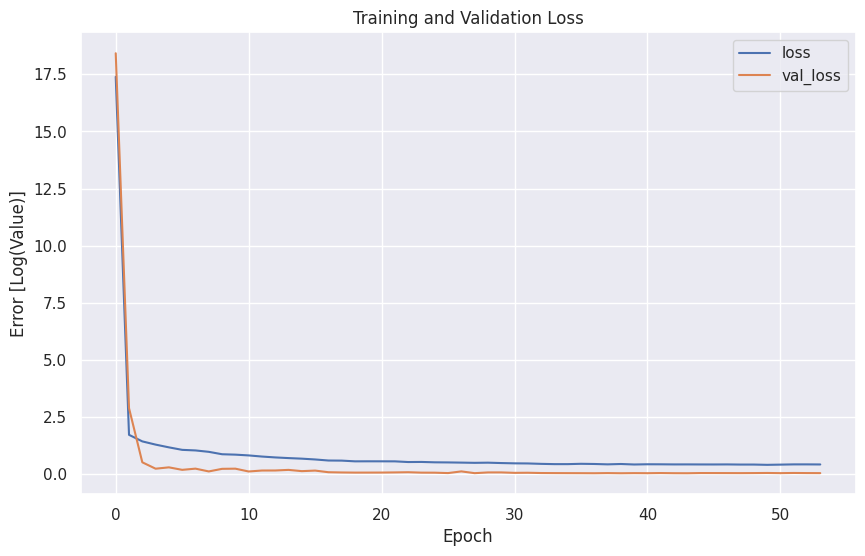

In [12]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Log(Value)]')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()

plot_loss(history)

113/113 - 0s - 4ms/step - loss: 0.0398 - mean_absolute_error: 0.1417

Test set Mean Abs Error (on log scale): 0.142
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R^2 Score on Test Data (Original Scale): 0.8986
MAE on Test Data (Original Scale): €403,443.01


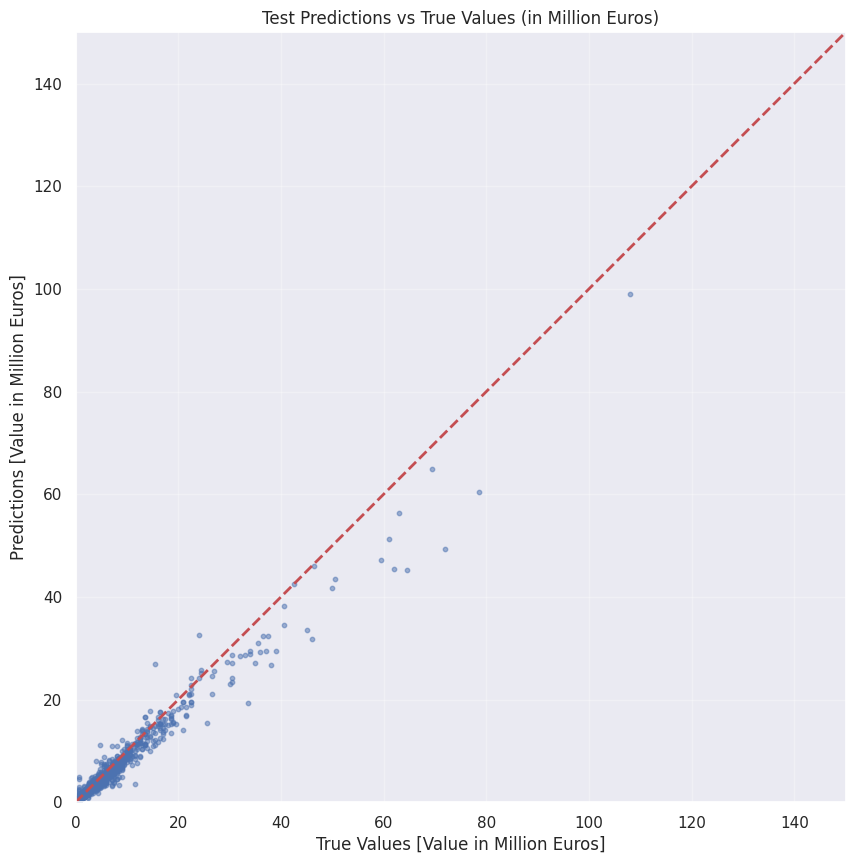

In [13]:
# Evaluate on test data (log scale)
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest set Mean Abs Error (on log scale): {mae:5.3f}")

# Make predictions (on the log scale)
test_predictions_log = model.predict(X_test).flatten()

# Transform predictions and true values back to the original Euro scale
test_predictions = np.expm1(test_predictions_log)
y_test_orig = np.expm1(y_test)

# Calculate R-squared and MAE on the original Euro scale
from sklearn.metrics import r2_score
r2 = r2_score(y_test_orig, test_predictions)
mae_euros = np.mean(np.abs(y_test_orig - test_predictions))
print(f"R^2 Score on Test Data (Original Scale): {r2:.4f}")
print(f"MAE on Test Data (Original Scale): €{mae_euros:,.2f}")

# Scatter plot of predictions vs true values (on original scale)
plt.figure(figsize=(10, 10))
plt.scatter(y_test_orig / 1e6, test_predictions / 1e6, alpha=0.5, s=10)
plt.xlabel('True Values [Value in Million Euros]')
plt.ylabel('Predictions [Value in Million Euros]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 150])
plt.ylim([0, 150])
plt.plot([0, 150], [0, 150], 'r--', linewidth=2)
plt.title('Test Predictions vs True Values (in Million Euros)')
plt.grid(True, alpha=0.3)
plt.show()

### 7. Save Model and Preprocessing Artifacts

In [14]:
import joblib
import json
import os

# Create a directory for the model artifacts
os.makedirs("Price Model", exist_ok=True)

# Save the Keras Model
model.save('Price Model/price_model.keras')

# Save the Scaler
joblib.dump(scaler, 'Price Model/price_scaler.gz')

# Save the list of model columns
with open('Price Model/price_model_columns.json', 'w') as f:
    json.dump(model_columns, f)

# Save the list of top nationalities
with open('Price Model/price_top_nationalities.json', 'w') as f:
    json.dump(top_nationalities.tolist(), f)

# Save the numerical columns list
with open('Price Model/price_numerical_columns.json', 'w') as f:
    json.dump(numerical_features, f)

print("\nModel artifacts saved successfully in the 'Price Model' directory.")


Model artifacts saved successfully in the 'Price Model' directory.
